<a href="https://colab.research.google.com/github/elvissoares/EQE595-SimMol/blob/main/notebooks/4_Ensemble_NVT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula Prática 04 - Dinâmica Molecular em Ensemble NVT

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares)

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

## Dinâmica Molecular em Ensemble NVT

- $N$: número de partículas
- $V$: volume
- $T$: temperatura

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

## Integrador de Langevin

A dinâmica de Langevin é dada por

$$dq = \frac{p}{m} dt$$
$$dp = - \nabla U(x) dt - \gamma p dt + \left(2 \gamma k_B T m\right)^{1/2} dW$$

onde $\gamma$ é um coeficiente de atrito e $dW$ é um processo estocástico gerado a partir de um número aleatório gaussiano com média

$$\langle dW \rangle = 0$$

e variância

$$\langle dW^2 \rangle = dt$$

Função que calcula o potencial de LJ entre pares

In [2]:
def ulj(r,epsilon=1.0,sigma=1.0):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

Função que calcula a derivada do potencial de LJ entre pares

In [3]:
def duljdr(r,epsilon=1.0,sigma=1.0):
    return -48*epsilon*((sigma/r)**12-0.5*(sigma/r)**6)/r


> ⚠️ Implemente o integrador de langevin usando o procedimento BAOA

Ref: https://arxiv.org/abs/2204.02105


In [4]:
class LJsystem():
    # Função que cria a classe
    def __init__(self,N, m = 1.0, epsilon = 1.0, sigma = 1.0, rcut = 2.5, dt = 0.003, integrator='verlet'):
        # número de partículas
        self.N = N

        # passo de tempo
        self.dt = dt

        # integrador de equações de movimento
        self.integrator = integrator

        # parametros dos atomos
        self.m = m
        self.sigma = sigma
        self.epsilon = epsilon

        # parametro de Langevin
        self.gamma = 0.3

        # parametro de cutoff da interação de LJ
        self.rcut = rcut

        # Arrays de posições
        self.r = np.zeros((self.N,3))

        # Arrays de velocidade
        self.v = np.zeros((self.N,3))

        # Arrays de aceleração
        self.a = np.zeros((self.N,3))

    def set_density(self,rho):
        self.rho = rho
        # calcular o tamanho da caixa necessária
        self.Vol = self.N/self.rho
        self.L = np.power(self.Vol,1/3.0)

    def initialize_positions(self):
        # Número de pontos em x e y
        Nx = Ny = Nz = int(np.ceil(np.power(self.N/4,1/3.0)))

        # Espaçamento entre os átomos
        dx = self.L/Nx
        dy = self.L/Ny
        dz = self.L/Nz

        # Posições possíveis em x e y numa rede cristalina tipo FCC
        id = 0
        for i in range(Nx):
            for j in range(Ny):
                for k in range(Nz):
                    if (id < self.N):
                        self.r[id][0] = i*dx
                        self.r[id][1] = j*dy
                        self.r[id][2] = k*dz
                        id +=1

                    if (id < self.N):
                        self.r[id][0] = i*dx
                        self.r[id][1] = (j+0.5)*dy
                        self.r[id][2] = (k+0.5)*dz
                        id +=1

                    if (id < self.N):
                        self.r[id][0] = (i+0.5)*dx
                        self.r[id][1] = j*dy
                        self.r[id][2] = (k+0.5)*dz
                        id +=1

                    if (id < self.N):
                        self.r[id][0] = (i+0.5)*dx
                        self.r[id][1] = (j+0.5)*dy
                        self.r[id][2] = k*dz
                        id +=1

    def initialize_velocities(self,kT= 1.0):
        self.kT = kT

        # sorteia uma distribuição normal com devio padrão proporcional a temperatura
        self.v = np.sqrt(self.kT/self.m)*np.random.randn(self.N,3)

        # remove o momento linear total
        self.v[:] -= self.v.mean(axis=0)

    def build_neighbor_list(self,rcell=2.8):
        """Construindo uma lista de vizinhos de Verlet dentro de uma região rcell"""
        self.rcell = rcell
        self.NL = [[] for _ in range(self.N)]
        for i in range(self.N):
            for j in range(i+1, self.N):
                # calcula distancia entre duas particulas
                rij = self.r[i]-self.r[j]
                # testa condição de contorno periodica para imagens
                rij[:] -= np.rint(rij/self.L)*self.L
                # calcula modulo da distancia
                rij_norm = np.linalg.norm(rij)
                # Vamos considerar somente interação dentro do raio de corte
                if rij_norm < self.rcell*self.sigma:
                    self.NL[i].append(j)

    def update_forces(self):
        self.a.fill(0.0)
        self.U = 0.0
        self.W = 0.0
        for i in range(self.N):
            for j in self.NL[i]: # <-------- troca os limites
                # calcula distancia entre duas particulas
                rij = self.r[i]-self.r[j]
                # testa condição de contorno periodica para imagens
                rij[:] -= np.rint(rij/self.L)*self.L
                # calcula modulo da distancia
                rij_norm = np.linalg.norm(rij)
                # Vamos considerar somente interação dentro do raio de corte
                if rij_norm < self.rcut*self.sigma:
                    # calcula a derivada do potencial
                    dudr = duljdr(rij_norm,self.epsilon,self.sigma)
                    # calcula aceleração na particula i
                    self.a[i] += -dudr*rij/rij_norm
                    # calcula aceleração na particula j usando 3ª Lei de Newton
                    self.a[j] += dudr*rij/rij_norm
                    # calcula energia interna
                    self.U += ulj(rij_norm,self.epsilon,self.sigma)
                    self.W += dudr*rij_norm

    def initialize(self,kT=1.0):
        self.initialize_positions()
        self.initialize_velocities(kT=kT)
        self.build_neighbor_list()
        self.update_forces()

    def potential_energy(self):
        return self.U

    def kinetic_energy(self):
        return 0.5*self.m*np.sum(self.v**2)

    def temperature(self):
        K = self.kinetic_energy()
        return 2*K/(3*self.N)

    def pressure(self):
        K = self.kinetic_energy()
        kT = self.temperature()
        return self.rho*kT + self.W/(3*self.Vol)

    def thermodynamic_properties(self):
        K = self.kinetic_energy()
        U = self.potential_energy()
        T = self.temperature()
        P = self.pressure()
        E = K + U
        return K, U, E, T, P

    def step(self):
        if self.integrator == 'verlet':
            # update das velocidades
            self.v[:] += 0.5*self.a*self.dt
            # update das posições
            self.r[:] += self.dt * self.v
            # condição de contorno periódica
            self.r[:] = self.r % self.L
            # calcula nova aceleração
            self.update_forces()
            # update das velocidades
            self.v[:] += 0.5*self.a*self.dt
        elif self.integrator == 'langevin':
            # calculando termo estocastico
            dW = np.random.randn(self.N,3)
            # usando método BAOA
            # passo B: update das velocidas somente com aceleração
            self.v[:] += self.a*self.dt
            # passo A: update das posições com metade do tempo
            self.r[:] += 0.5* self.dt * self.v
            # passo O: update com termo estocastico
            self.v[:] = self.v*np.exp(-self.gamma*self.dt) \
                      + np.sqrt((1-np.exp(-2*self.gamma*self.dt))*self.kT/self.m)*dW
            # passo A: update das posições com metade do tempo
            self.r[:] += 0.5* self.dt * self.v
            # condição de contorno periódica
            self.r[:] = self.r % self.L
            # calcula nova aceleração
            self.update_forces()


    def run(self,N_steps,print_every=50,update_list=20):
        self.N_steps = N_steps
        self.print_every = print_every # steps to print output
        self.update_list = update_list

        print("iter\tK\tU\tE\tT\tP")
        self.data = pd.DataFrame({'t': [], 'K': [], 'U': [], 'E': [], 'T': [], 'P': []})

        for step in range(1,self.N_steps+1):

            if step % self.update_list == 0:
                self.build_neighbor_list()

            self.step()

            if step % self.print_every == 0:
                K, U, E, T, P = self.thermodynamic_properties()

                print(f"{step:5d}\t{K:.4f}\t{U:.4f}\t{E:.4f}\t{T:.4f}\t{P:.4f}")
                new_row = pd.DataFrame({'t': [step], 'K': [K], 'U': [U], 'E': [E], 'T': [T], 'P': [P]})
                self.data = pd.concat([self.data, new_row], ignore_index=True)

In [5]:
rho = 0.2
kT = 1.5

N_atoms=256

In [6]:
lj = LJsystem(N=N_atoms,m=1.0,epsilon=1.0,sigma=1.0, rcut=2.5, dt=0.003, integrator='langevin')
lj.set_density(rho=rho)
lj.initialize(kT=kT)

Gráfico com as posições iniciais das partículas

Text(0, 0.5, 'y')

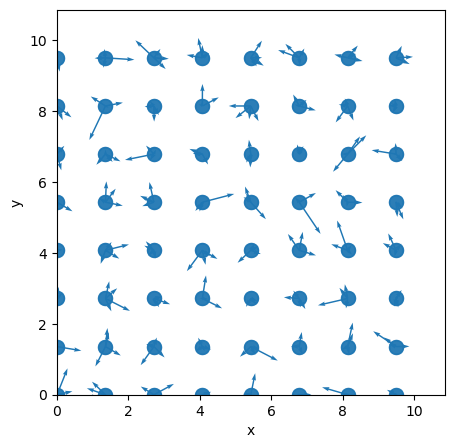

In [7]:
plt.figure(figsize=(5,5))
plt.plot(lj.r[:,0],lj.r[:,1],'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(lj.r[:,0],lj.r[:,1],lj.v[:,0],lj.v[:,1],color='C0') # vetor de velocidade

plt.xlim(0,lj.L)
plt.ylim(0,lj.L)

plt.xlabel('x')
plt.ylabel('y')

In [8]:
lj.run(N_steps=10000, print_every=50, update_list=20)

iter	K	U	E	T	P
   50	599.5786	-157.7107	441.8679	1.5614	0.5447
  100	646.3327	-209.5984	436.7343	1.6832	0.3125
  150	673.7448	-256.5534	417.1914	1.7545	0.2382
  200	691.0497	-301.8994	389.1503	1.7996	0.4684
  250	672.7220	-282.6975	390.0244	1.7519	0.3787
  300	685.6359	-297.7815	387.8545	1.7855	0.4449
  350	659.1655	-285.0939	374.0716	1.7166	0.3433
  400	646.8987	-289.1457	357.7530	1.6846	0.3792
  450	663.7988	-285.9856	377.8132	1.7286	0.3838
  500	634.0257	-282.5910	351.4347	1.6511	0.3649
  550	649.9108	-309.4206	340.4902	1.6925	0.4730
  600	635.4685	-307.5462	327.9223	1.6549	0.4036
  650	633.3863	-313.6318	319.7545	1.6494	0.3727
  700	637.0666	-324.2871	312.7795	1.6590	0.3719
  750	648.4897	-332.0939	316.3958	1.6888	0.4297
  800	637.0506	-324.6253	312.4253	1.6590	0.3743
  850	635.3145	-328.7014	306.6130	1.6545	0.4318
  900	610.7029	-311.7986	298.9043	1.5904	0.3632
  950	628.5456	-312.3898	316.1558	1.6368	0.3385
 1000	616.6109	-312.0015	304.6094	1.6058	0.3627
 1050	622.6686	-321.7938	

Gráfico com as posições finais

Text(0, 0.5, 'y')

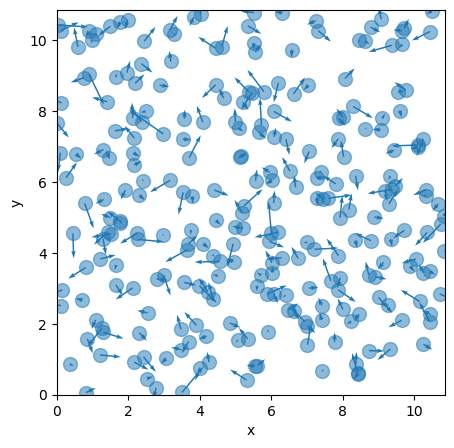

In [9]:
plt.figure(figsize=(5,5))
plt.plot(lj.r[:,0],lj.r[:,1],'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(lj.r[:,0],lj.r[:,1],lj.v[:,0],lj.v[:,1],color='C0') # vetor de velocidade

plt.xlim(0,lj.L)
plt.ylim(0,lj.L)

plt.xlabel('x')
plt.ylabel('y')

Gerar Output com qtds de interesse

In [10]:
simdata = lj.data

# Save as tab-separated .txt file
simdata.to_csv(f'simdata-N={N_atoms}-rho={rho:.3f}-kT={kT:.3f}.txt', sep='\t', index=False)

Distribuição das partículas

(0.0, 0.2)

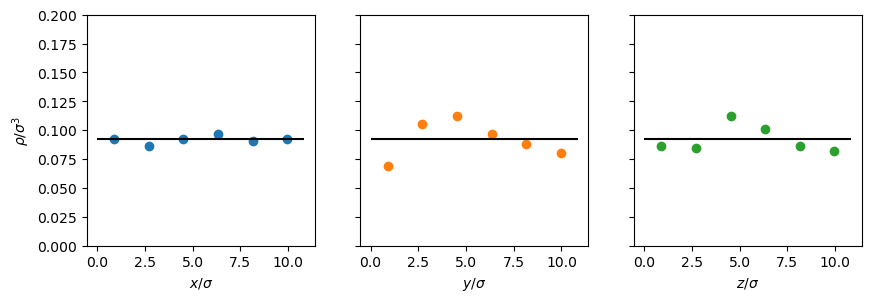

In [11]:
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(10,3))

n, bins = np.histogram(lj.r[:,0],bins=6,range=(0,lj.L),density=True) # é uma outra forma de fazer histograma
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[0].scatter(meanbins,n,marker='o',color='C0')
axs[0].hlines(y=rho*lj.L**2/lj.N,xmin=0,xmax=lj.L,color='k')
axs[0].set_xlabel(r'$x/\sigma$')
axs[0].set_ylabel(r'$\rho/\sigma^3$')

n, bins = np.histogram(lj.r[:,1],bins=6,range=(0,lj.L),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[1].scatter(meanbins,n,marker='o',color='C1')
axs[1].hlines(y=rho*lj.L**2/lj.N,xmin=0,xmax=lj.L,color='k')
axs[1].set_xlabel(r'$y/\sigma$')

n, bins = np.histogram(lj.r[:,2],bins=6,range=(0,lj.L),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[2].scatter(meanbins,n,marker='o',color='C2')
axs[2].hlines(y=rho*lj.L**2/lj.N,xmin=0,xmax=lj.L,color='k')
axs[2].set_xlabel(r'$z/\sigma$')

axs[0].set_ylim(0,0.2)

Distribuição de Velocidades

(0.0, 0.5)

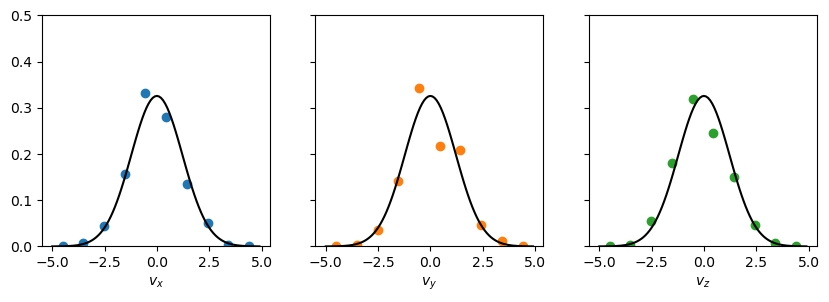

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(10,3))

vx = np.arange(-5,5,0.1)
fvx = np.exp(-vx**2/(2*kT))/np.sqrt(2*np.pi*kT)

n, bins = np.histogram(lj.v[:,0],bins=10,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[0].scatter(meanbins,n,marker='o',color='C0')
axs[0].plot(vx,fvx,'k')
axs[0].set_xlabel(r'$v_x$')

n, bins = np.histogram(lj.v[:,1],bins=10,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[1].scatter(meanbins,n,marker='o',color='C1')
axs[1].plot(vx,fvx,'k')
axs[1].set_xlabel(r'$v_y$')

n, bins = np.histogram(lj.v[:,2],bins=10,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[2].scatter(meanbins,n,marker='o',color='C2')
axs[2].plot(vx,fvx,'k')
axs[2].set_xlabel(r'$v_z$')

axs[0].set_ylim(0,0.5)

Gráfico da evolução de $E$, $U$ e $T$ como função dos passos de iteração

Text(0, 0.5, '$k_B T/\\epsilon$')

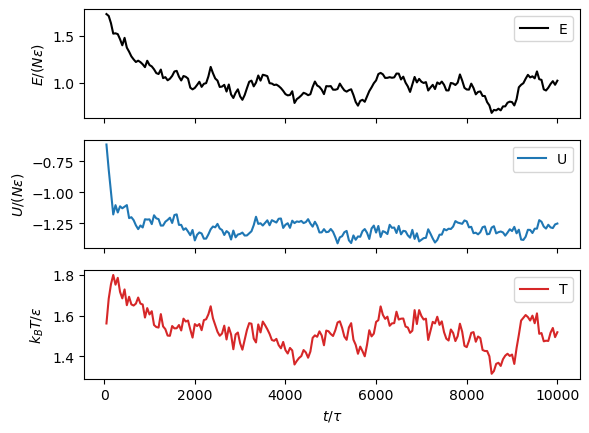

In [13]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(simdata['t'],simdata['E']/lj.N,'k',label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel(r'$E/(N\epsilon)$')

axs[1].plot(simdata['t'],simdata['U']/lj.N,label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel(r'$U/(N\epsilon)$')

axs[2].plot(simdata['t'],simdata['T'],color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_xlabel(r'$t/\tau$')
axs[2].set_ylabel(r'$k_B T/\epsilon$')

> ⚠️ Analise as distribuições de energia interna, temperatura e pressão.


In [14]:
simdata['T'].mean()

np.float64(1.5265747803039529)

In [15]:
simdata['T'].std()

np.float64(0.08427651919117023)

Text(0.5, 0, 'T')

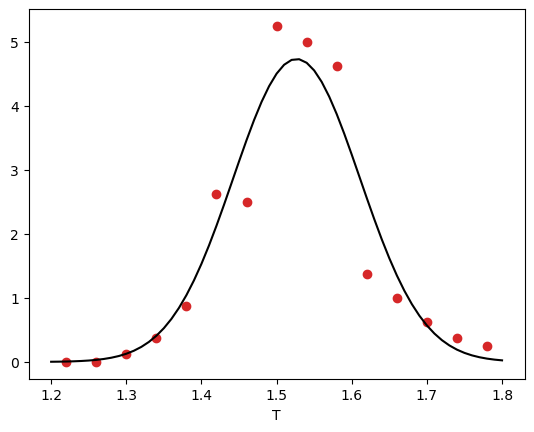

In [16]:
x = np.arange(1.2,1.8,0.01)

n, bins = np.histogram(simdata['T'],bins=15,range=(x.min(),x.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])

mu = simdata['T'].mean()
sigma = simdata['T'].std()

plt.scatter(meanbins,n,marker='o',color='C3')
plt.plot(x, np.exp(-0.5*((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma),color='k')

plt.xlabel('T')

In [17]:
simdata['U'].mean()

np.float64(-328.7063028090255)

In [18]:
simdata['U'].std()

np.float64(21.83069898996675)

Text(0.5, 0, 'U')

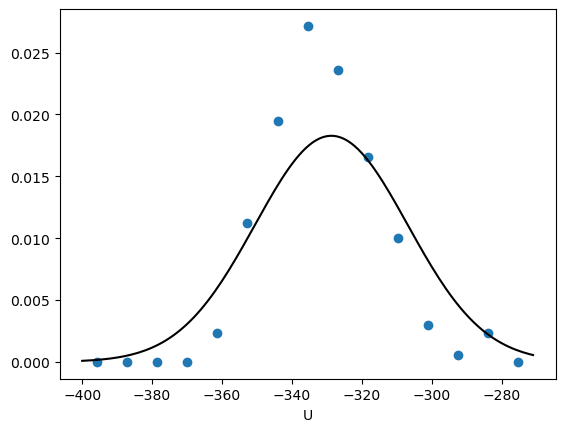

In [19]:
x = np.arange(-400,-270,1)

n, bins = np.histogram(simdata['U'],bins=15,range=(x.min(),x.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])

mu = simdata['U'].mean()
sigma = simdata['U'].std()

plt.scatter(meanbins,n,marker='o',color='C0')
plt.plot(x, np.exp(-0.5*((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma),color='k')

plt.xlabel('U')